In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [280]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.models import load_model

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [170]:
class Config:
    BASE_DIR = Path('/content/drive/MyDrive/College/machine_learning_2/submissions/1')
    DATA_DIR = BASE_DIR / 'datasets'
    FEAT_DIR = DATA_DIR / 'feature_embeddings'
    MODEL_DIR = BASE_DIR / 'models'
    RESULT_DIR = BASE_DIR / 'results'

In [171]:
X_train = pd.read_csv(Config.FEAT_DIR/ 'X_train_word2vec.csv', index_col='Unnamed: 0')
X_valid = pd.read_csv(Config.FEAT_DIR/ 'X_valid_word2vec.csv', index_col='Unnamed: 0')

y_train = pd.read_csv(Config.FEAT_DIR/ 'y_train.csv', index_col='Unnamed: 0')
y_valid = pd.read_csv(Config.FEAT_DIR/ 'y_valid.csv', index_col='Unnamed: 0')

In [172]:
X_train.head()

,w2v_0,w2v_1,w2v_2,w2v_3,w2v_4,w2v_5,w2v_6,w2v_7,w2v_8,w2v_9,...,w2v_290,w2v_291,w2v_292,w2v_293,w2v_294,w2v_295,w2v_296,w2v_297,w2v_298,w2v_299
0,0.007801,0.007271,0.056149,0.104170,-0.041029,-0.009192,0.039058,-0.065662,0.053402,0.058339,...,-0.072690,0.066802,-0.075329,0.008947,-0.018997,-0.027270,-0.009950,-0.044448,0.009347,-0.056897
1,-0.004851,0.035265,0.039960,0.072817,-0.031159,0.008666,0.015080,-0.072557,0.082459,0.043270,...,-0.026894,0.053776,-0.049920,-0.014080,0.009533,-0.072636,-0.038792,-0.036564,-0.031219,-0.007193
2,0.015247,0.005701,0.019336,0.120636,-0.056817,0.013018,0.018738,-0.067665,0.088968,0.077356,...,-0.036953,0.071148,-0.063797,0.024232,-0.021028,-0.030299,-0.010727,-0.060344,-0.002789,-0.036179
3,0.033739,0.014165,0.014005,0.111028,-0.066243,0.000270,0.031023,-0.057488,0.048414,0.047948,...,-0.044280,0.031794,-0.076340,0.044865,-0.035649,-0.044508,0.001078,-0.069224,0.006071,-0.034711
4,0.001332,0.004079,0.023041,0.097417,-0.092767,0.016627,0.055037,-0.056360,0.072968,0.069730,...,-0.019347,0.058442,-0.052933,0.014080,-0.009634,-0.025273,-0.020354,-0.068289,0.028027,-0.045768


In [173]:
X_train.shape

(11314, 300)

In [174]:
y_train.head()

,target
0,7
1,4
2,4
3,1
4,14


In [175]:
y_train_encoded = to_categorical(y_train)
y_train_encoded

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [176]:
y_train_encoded.shape

(11314, 20)

In [177]:
y_valid_encoded = to_categorical(y_valid)

In [178]:
# Convert to NumPy arrays
X_train = np.array(X_train)
X_valid = np.array(X_valid)

In [179]:
# Reshape for LSTM: (samples, time_steps=1, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))  # (samples, 1, 300)
X_valid = X_valid.reshape((X_valid.shape[0], 1, X_valid.shape[1]))  # (samples, 1, 300)

In [180]:
# Define the LSTM architecture
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),  # Input layer
    LSTM(128, return_sequences=True),  # 1st LSTM layer
    Dropout(0.3),
    LSTM(64, return_sequences=False),  # 2nd LSTM layer
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(y_train_encoded.shape[1], activation='softmax')  # Multi-class output
])

In [181]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [182]:
# Add EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [183]:
BATCH_SIZE = 32
EPOCHS = 30

In [184]:
# Train the model
history = model.fit(X_train,
                    y_train_encoded,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_valid, y_valid_encoded),
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/30
354/354 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.0925 - loss: 2.7793 - val_accuracy: 0.2430 - val_loss: 2.1536
Epoch 2/30
354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.2697 - loss: 2.0558 - val_accuracy: 0.3930 - val_loss: 1.7363
Epoch 3/30
354/354 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.3864 - loss: 1.6857 - val_accuracy: 0.4456 - val_loss: 1.5348
Epoch 4/30
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4584 - loss: 1.4737 - val_accuracy: 0.5011 - val_loss: 1.4049
Epoch 5/30
354/354 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.5076 - loss: 1.3334 - val_accuracy: 0.5406 - val_loss: 1.3020
Epoch 6/30
354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5424 - loss: 1.2544 - val_accuracy: 0.5428 - val_loss: 1.2806
Epoch 7/30
354/354 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.5693 - loss: 1.1751 - val_accuracy: 0.5605 - val_loss: 1.2327
Epoch 8/30
354/354 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.6152 - loss: 1.1089 - val_acc

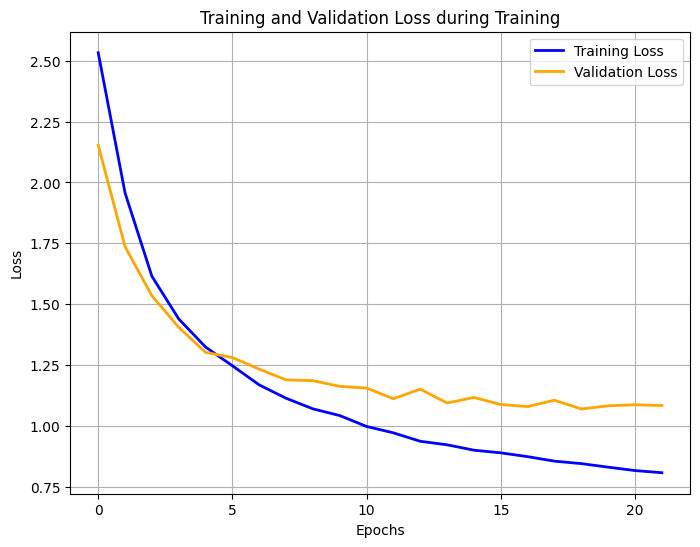

In [185]:
# Extract training loss and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot both training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training Loss', color='blue', linewidth=2)
plt.plot(val_loss, label='Validation Loss', color='orange', linewidth=2)
plt.title('Training and Validation Loss during Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [189]:
y_pred_valid = model.predict(X_valid)
y_pred_labels = np.argmax(y_pred_valid, axis=1)
y_pred_labels

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


array([ 5, 16, 12, ..., 15, 11, 15])

In [190]:
# Evaluate
lstm_results = {
    'Model': 'LSTM',
    'Embedding': 'word2vec',
    'Accuracy': accuracy_score(y_valid, y_pred_labels),
    'Precision': precision_score(y_valid, y_pred_labels, average='weighted'),
    'Recall': recall_score(y_valid, y_pred_labels, average='weighted'),
    'F1 Score': f1_score(y_valid, y_pred_labels, average='weighted')
}
lstm_results

{'Model': 'LSTM',
 'Embedding': 'word2vec',
 'Accuracy': 0.6571959638874137,
 'Precision': 0.648351084947082,
 'Recall': 0.6571959638874137,
 'F1 Score': 0.6470698230478918}

## Training with more layers

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = y_train_encoded.shape[1]

In [ ]:
# lstm_model with more layers
lstm_model_v2 = Sequential([
    Input(shape=input_shape),  # Input layer
    LSTM(128, return_sequences=True),  # 1st LSTM layer
    Dropout(0.3),
    LSTM(64, return_sequences=True),  # 2nd LSTM layer (more layers added)
    Dropout(0.3),
    LSTM(32, return_sequences=False),  # 3rd LSTM layer
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')  # Multi-class output
])

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Training with a learning rate scheduler and more layers

In [211]:
# Custom Learning Rate Scheduler
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0007,  # Starting learning rate
    decay_steps=5000,               # Steps before decay
    decay_rate=0.95,                # Small decay rate for smoother changes
    staircase=True                  # Decay after every `decay_steps`
)

In [212]:
# lstm_model with more layers
lstm_model_v2 = Sequential([
    Input(shape=input_shape),  # Input layer
    LSTM(128, return_sequences=True),  # 1st LSTM layer
    Dropout(0.3),
    LSTM(64, return_sequences=True),  # 2nd LSTM layer (more layers added)
    Dropout(0.3),
    LSTM(32, return_sequences=False),  # 3rd LSTM layer
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')  # Multi-class output
])

In [213]:
# Compile the model with custom learning rate scheduler
optimizer = Adam(learning_rate=lr_schedule)
lstm_model_v2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [214]:
EPOCHS = 50
BATCH_SIZE = 64

In [215]:
# Add EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [216]:
# Train the model
history = lstm_model_v2.fit(X_train, y_train_encoded, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_valid, y_valid_encoded), callbacks=[early_stopping])

Epoch 1/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.0566 - loss: 2.9733 - val_accuracy: 0.1144 - val_loss: 2.6189
Epoch 2/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.1103 - loss: 2.5245 - val_accuracy: 0.1564 - val_loss: 2.3324
Epoch 3/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.1628 - loss: 2.3189 - val_accuracy: 0.1851 - val_loss: 2.2383
Epoch 4/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.1955 - loss: 2.1886 - val_accuracy: 0.2353 - val_loss: 2.0433
Epoch 5/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.2334 - loss: 2.0015 - val_accuracy: 0.2626 - val_loss: 1.9706
Epoch 6/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.2649 - loss: 1.9221 - val_accuracy: 0.2764 - val_loss: 1.9097
Epoch 7/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.2911 - loss: 1.8652 - val_accuracy: 0.3266 - val_loss: 1.8065
Epoch 8/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.3288 - loss: 1.7761 - val_acc

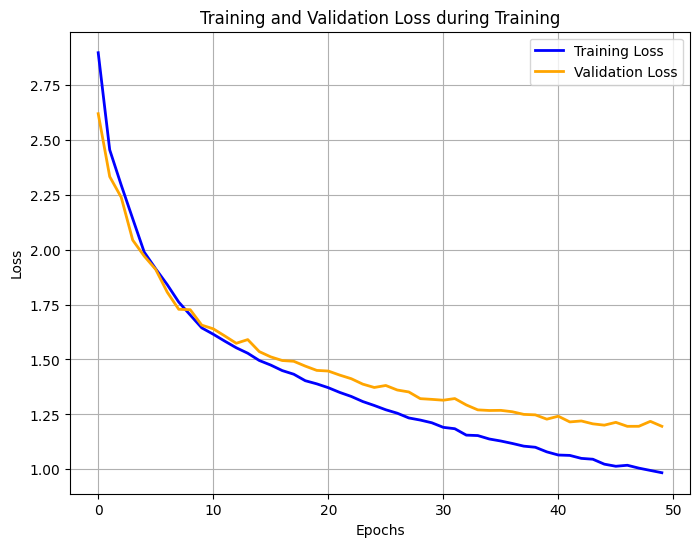

In [217]:
# Extract training loss and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot both training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training Loss', color='blue', linewidth=2)
plt.plot(val_loss, label='Validation Loss', color='orange', linewidth=2)
plt.title('Training and Validation Loss during Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [218]:
# Predict on validation set
y_pred_prob = lstm_model_v2.predict(X_valid)
# Convert probabilities to predicted labels
y_pred_labels = y_pred_prob.argmax(axis=1)
y_pred_labels

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


array([ 5, 16, 12, ..., 15, 11, 15])

In [219]:
# Evaluate the model
lstm_results = {
    'Model': 'LSTM_v2',
    'Embedding': 'word2vec',
    'Accuracy': accuracy_score(y_valid, y_pred_labels),
    'Precision': precision_score(y_valid, y_pred_labels, average='weighted'),
    'Recall': recall_score(y_valid, y_pred_labels, average='weighted'),
    'F1 Score': f1_score(y_valid, y_pred_labels, average='weighted')
}
lstm_results

{'Model': 'LSTM_v2',
 'Embedding': 'word2vec',
 'Accuracy': 0.588688263409453,
 'Precision': 0.5798736779346698,
 'Recall': 0.588688263409453,
 'F1 Score': 0.5738599305538925}

## Training with less layers

In [220]:
# Define the LSTM architecture with fewer layers
lstm_model_v3 = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),  # Input layer
    LSTM(128, return_sequences=False),  # 1st LSTM layer with reduced output
    Dropout(0.3),                        # Dropout layer to prevent overfitting
    Dense(32, activation='relu'),        # Dense layer
    Dense(y_train_encoded.shape[1], activation='softmax')  # Multi-class output
])

In [221]:
lstm_model_v3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [222]:
BATCH_SIZE = 128
EPOCHS = 40

In [224]:
# Add EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [225]:
history = lstm_model_v3.fit(X_train,
                    y_train_encoded,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_valid, y_valid_encoded),
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/40
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.1068 - loss: 2.9548 - val_accuracy: 0.2345 - val_loss: 2.5426
Epoch 2/40
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2687 - loss: 2.3382 - val_accuracy: 0.3895 - val_loss: 1.8753
Epoch 3/40
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4084 - loss: 1.7963 - val_accuracy: 0.4610 - val_loss: 1.6253
Epoch 4/40
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4673 - loss: 1.5595 - val_accuracy: 0.5127 - val_loss: 1.4730
Epoch 5/40
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.5221 - loss: 1.4043 - val_accuracy: 0.5435 - val_loss: 1.3794
Epoch 6/40
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5560 - loss: 1.2993 - val_accuracy: 0.5624 - val_loss: 1.3201
Epoch 7/40
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5755 - loss: 1.2569 - val_accuracy: 0.5820 - val_loss: 1.2641
Epoch 8/40
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6005 - loss: 1.1675 - val_accuracy: 0.5972 - v

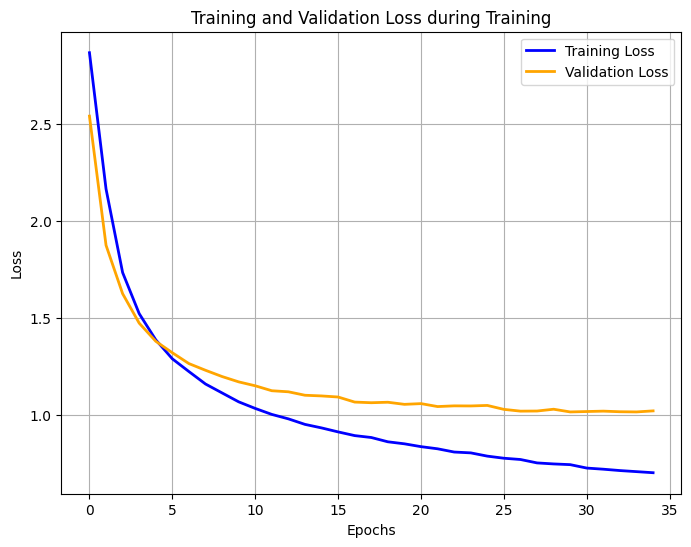

In [226]:
# Extract training loss and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot both training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training Loss', color='blue', linewidth=2)
plt.plot(val_loss, label='Validation Loss', color='orange', linewidth=2)
plt.title('Training and Validation Loss during Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [227]:
# Predict on validation set
y_pred_prob = lstm_model_v3.predict(X_valid)
# Convert probabilities to predicted labels
y_pred_labels = y_pred_prob.argmax(axis=1)
y_pred_labels

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


array([ 1, 18, 12, ..., 15, 11, 15])

In [228]:
# Evaluate the model
lstm_results = {
    'Model': 'LSTM_v3',
    'Embedding': 'word2vec',
    'Accuracy': accuracy_score(y_valid, y_pred_labels),
    'Precision': precision_score(y_valid, y_pred_labels, average='weighted'),
    'Recall': recall_score(y_valid, y_pred_labels, average='weighted'),
    'F1 Score': f1_score(y_valid, y_pred_labels, average='weighted')
}
lstm_results

{'Model': 'LSTM_v3',
 'Embedding': 'word2vec',
 'Accuracy': 0.6818906001062135,
 'Precision': 0.6768217239988686,
 'Recall': 0.6818906001062135,
 'F1 Score': 0.6766168190873636}

In [231]:
lstm_results['Model'] = 'LSTM'

In [235]:
all_results = pd.read_csv(Config.RESULT_DIR / 'results.csv', index_col='Unnamed: 0')
all_results.head()

,Model,Accuracy,Precision,Recall,F1 Score,Embedding
0,SVM,0.749071,0.760012,0.749071,0.750662,tf_idf
1,Logistic Regression,0.744822,0.748750,0.744822,0.743840,tf_idf
2,Multinomial Naive Bayes,0.740308,0.755364,0.740308,0.734480,tf_idf
3,Multinomial Naive Bayes,0.712161,0.725300,0.712161,0.712840,bow
4,SVM,0.691450,0.693950,0.691450,0.686917,word2vec


In [236]:
# Append lstm_results to all_results DataFrame
all_results = pd.concat([all_results, pd.DataFrame([lstm_results])], ignore_index=True)
all_results = all_results.sort_values(by='F1 Score', ascending=False)
all_results

,Model,Accuracy,Precision,Recall,F1 Score,Embedding
0,SVM,0.749071,0.760012,0.749071,0.750662,tf_idf
1,Logistic Regression,0.744822,0.748750,0.744822,0.743840,tf_idf
2,Multinomial Naive Bayes,0.740308,0.755364,0.740308,0.734480,tf_idf
3,Multinomial Naive Bayes,0.712161,0.725300,0.712161,0.712840,bow
4,SVM,0.691450,0.693950,0.691450,0.686917,word2vec
5,Logistic Regression,0.685608,0.691856,0.685608,0.686694,bow
24,LSTM,0.681891,0.676822,0.681891,0.676617,word2vec
6,Logistic Regression,0.668879,0.660275,0.668879,0.657294,word2vec
7,Logistic Regression,0.649495,0.644230,0.649495,0.643579,glove
8,Logistic Regression,0.642592,0.640437,0.642592,0.640184,doc2vec


In [237]:
all_results.to_csv(Config.RESULT_DIR / 'results.csv')

## Retraining the model (using training and validation set and testing on test set)

In [266]:
X_test = pd.read_csv(Config.FEAT_DIR/ 'X_test_word2vec.csv', index_col='Unnamed: 0')
y_test = pd.read_csv(Config.FEAT_DIR/ 'y_test.csv', index_col='Unnamed: 0')

In [267]:
# Concatenate the training and validation sets
X_combined = np.concatenate([X_train, X_valid], axis=0)
y_combined = np.concatenate([y_train, y_valid], axis=0)
X_combined.shape

(15080, 1, 300)

In [268]:
y_combined_encoded = to_categorical(y_combined)

In [269]:
y_test_encoded = to_categorical(y_test)
X_test = np.array(X_test)
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [270]:
X_test.shape

(3766, 1, 300)

In [271]:
y_test_encoded.shape

(3766, 20)

In [272]:
# Define the LSTM architecture
final_lstm_model = Sequential([
    Input(shape=(X_combined.shape[1], X_combined.shape[2])),  # Input layer
    LSTM(128, return_sequences=False),  # 1st LSTM layer with reduced output
    Dropout(0.3),                        # Dropout layer to prevent overfitting
    Dense(32, activation='relu'),        # Dense layer
    Dense(y_test_encoded.shape[1], activation='softmax')  # Multi-class output
])

In [273]:
final_lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [274]:
history = final_lstm_model.fit(X_combined,
                    y_combined_encoded,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_test, y_test_encoded),
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.1140 - loss: 2.9272 - val_accuracy: 0.2629 - val_loss: 2.2690
Epoch 2/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.3170 - loss: 2.0847 - val_accuracy: 0.4575 - val_loss: 1.6825
Epoch 3/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.4626 - loss: 1.6259 - val_accuracy: 0.5396 - val_loss: 1.4398
Epoch 4/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5269 - loss: 1.4053 - val_accuracy: 0.5791 - val_loss: 1.3082
Epoch 5/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5720 - loss: 1.2547 - val_accuracy: 0.6065 - val_loss: 1.2257
Epoch 6/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5924 - loss: 1.2011 - val_accuracy: 0.6256 - val_loss: 1.1682
Epoch 7/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6220 - loss: 1.1210 - val_accuracy: 0.6360 - val_loss: 1.1322
Epoch 8/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6429 - loss: 1.0739 - val_accu

In [277]:
# Predict on validation set
y_pred_prob = final_lstm_model.predict(X_valid)
# Convert probabilities to predicted labels
y_pred_labels = y_pred_prob.argmax(axis=1)
y_pred_labels

# Evaluate the model
lstm_results = {
    'Model': 'final_lstm',
    'Embedding': 'word2vec',
    'Accuracy': accuracy_score(y_valid, y_pred_labels),
    'Precision': precision_score(y_valid, y_pred_labels, average='weighted'),
    'Recall': recall_score(y_valid, y_pred_labels, average='weighted'),
    'F1 Score': f1_score(y_valid, y_pred_labels, average='weighted')
}
lstm_results

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


{'Model': 'final_lstm',
 'Embedding': 'word2vec',
 'Accuracy': 0.7748274030801912,
 'Precision': 0.7735525042928535,
 'Recall': 0.7748274030801912,
 'F1 Score': 0.7711508140561409}

The final LSTM model has an F1-score of 0.77

### Saving the final LSTM model

In [278]:
# Save the LSTM model
final_lstm_model.save(Config.MODEL_DIR / 'lstm_model.keras')

In [279]:
# Load the saved model
loaded_lstm_model = load_model(Config.MODEL_DIR / 'lstm_model.keras')

In [281]:
# Predict on validation set
y_pred_prob = loaded_lstm_model.predict(X_valid)
# Convert probabilities to predicted labels
y_pred_labels = y_pred_prob.argmax(axis=1)

f1_score(y_valid, y_pred_labels, average='weighted')

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


0.7711508140561409

The final LSTM model has an f1-score of 0.77